In [196]:
import numpy as np
import sys
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import utilities as utils 

onecol = 3.42
onep5 = 4.5
twocol = 7

ext = ".jpg"

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 8
plt.rcParams['lines.linewidth'] = 1.5

color1 = (.6,.06,.06)
color2 = (.42,.6,.06)
color3 = (.15,.06,.6)

def rec(x):
    return (x + np.abs(x))/2

def v_std(f,meanax = 0,indices = [0,1],axis =-1):
    
    return np.take(np.std(f,axis = meanax),indices,axis)

def resp(f,axis = -1,square = False,indices = [0,1],meanfirst = True,meanax = 0):
    if meanfirst:
        r = np.mean(f,axis = meanax,keepdims = True)
    else:
        r = np.copy(f)
    
    R = 0
    
    for i in indices:
        R += rec(np.take(r,i,axis = axis))**2
    
    R = np.mean(R,meanax)
    
    if square == False:
        R = np.sqrt(R)

    return R

# GSM Figures
- Additivity Index at 2 values of SNR
- the rotated COS for noisy and noiseless 
- WTA plots for noisy and noiseless

(3, 500, 1, 60, 2)
(3, 20, 3, 2)
(50, 1, 441, 2)


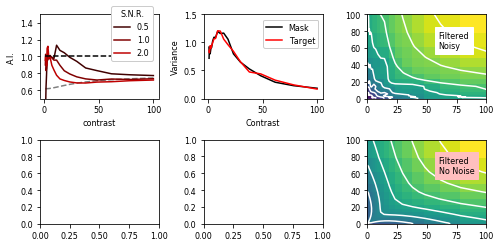

In [217]:
SNR = ["0.5","1.0","2.0"]

#Cross-Orientation suppression

noisy_COS_V = np.array([np.array(utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_{}_COS_1.0.pkl".format(snr))) for snr in SNR])
clean_COS_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_COS_1.0.pkl"))

print(noisy_COS_V.shape)

noisy_COS_response = np.reshape(resp(noisy_COS_V,meanax = (1,2)),[len(SNR),20,3])
clean_COS_response = np.reshape(resp(clean_COS_V,meanax = (0)),[20,3])

noisy_COS_std = np.reshape(v_std(noisy_COS_V,meanax = (1,2)),[len(SNR),20,3,2])
clean_COS_std = np.reshape(v_std(clean_COS_V,meanax = (0)),[20,3,2])

c = np.logspace(0,2,20)

clean_AI = clean_COS_response[:,0]/(clean_COS_response[:,1] + clean_COS_response[:,2])
noisy_AI = noisy_COS_response[:,:,0]/(noisy_COS_response[:,:,1] + noisy_COS_response[:,:,2])
fig,sub = plt.subplots(2,3,figsize = (twocol,onecol))

sub[0,0].plot(c,clean_AI,"--",color = (0,0,0,.5))

for k in range(len(noisy_AI)):
    sub[0,0].plot(c,noisy_AI[k],color = (.25*(k+1),0,0),label = "{}".format(SNR[k]))
    
sub[0,0].plot(c,np.ones_like(c),"k--")
    
sub[0,0].legend(loc = (.6,.45),framealpha = 1,title = "S.N.R.")
sub[0,0].set_xlabel("contrast")
sub[0,0].set_ylabel("A.I.")
sub[0,0].set_ylim([.5,1.5])
print(noisy_COS_std.shape)
sub[0,1].plot(c,noisy_COS_std[1,:,1,0]**2,"k",label = "Mask")
sub[0,1].plot(c,noisy_COS_std[1,:,2,0]**2,"r",label = "Target")
sub[0,1].set_ylabel("Variance")
sub[0,1].set_xlabel("Contrast")
sub[0,1].set_ylim([0,1.5])
sub[0,1].legend(loc = (.5,.6),framealpha = 1)

noisy_COS_rot_V = np.array(utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_1.0_COS_rot_1.0.pkl"))
clean_COS_rot_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_COS_rot_1.0.pkl"))

print(noisy_COS_rot_V.shape)

def symm(x):
    return (x + x.T)/2

from scipy.ndimage.filters import gaussian_filter as gfilt

c = np.concatenate([[0],np.logspace(0,2,20)])

noisy_COS_rot_response = symm(np.reshape(resp(noisy_COS_rot_V,meanax = (0,1)),[21,21]))
clean_COS_rot_response = symm(np.reshape(resp(clean_COS_rot_V,meanax = (0)),[21,21]))

noisy_COS_rot_response = gfilt(noisy_COS_rot_response,.75)
clean_COS_rot_response = gfilt(clean_COS_rot_response,.75)

ln = np.linspace(np.min(noisy_COS_rot_response), np.max(noisy_COS_rot_response),10)
lc = np.linspace(np.min(clean_COS_rot_response), np.max(clean_COS_rot_response),10)

lcol = [(1,1,1,1) for x in np.linspace(1,.25,len(lc))]

sub[0,2].pcolor(c,c,noisy_COS_rot_response)
sub[0,2].contour(c,c,noisy_COS_rot_response,ln,colors = lcol)
sub[0,2].text(60,60,"Filtered\nNoisy",backgroundcolor = (1,1,1,1))

sub[1,2].pcolor(c,c,clean_COS_rot_response)
sub[1,2].contour(c,c,clean_COS_rot_response,lc,colors = lcol)
sub[1,2].text(60,60,"Filtered\nNo Noise",backgroundcolor = (1,.75,.75,1))

plt.tight_layout()
plt.show()


(3, 50, 1, 400, 2)
1.62377673919
37.9269019073
78.4759970351
100.0


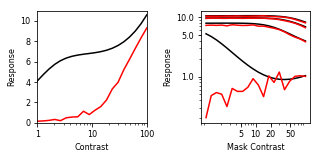

In [252]:
SNR = ["0.5","1.0","2.0"]

noisy_full_COS_V = np.array([np.array(utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_{}_full_COS_1.0.pkl".format(snr))) for snr in SNR])
clean_full_COS_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_full_COS_1.0.pkl"))

print(noisy_full_COS_V.shape)

noisy_full_COS = np.reshape(resp(noisy_full_COS_V,meanax = (1,2)),[len(SNR),20,20])
clean_full_COS = np.reshape(resp(clean_full_COS_V,meanax = (0)),[20,20])

c = np.logspace(0,2,20)

fig,sub = plt.subplots(1,2,figsize = (onep5,onep5/2))

sub[0].plot(c,noisy_full_COS[0,0,:],"r")
sub[0].plot(c,clean_full_COS[0,:],"k")
sub[0].set_ylim([0,11])
sub[0].set_xlim([1,100])
sub[0].set_xscale("log")
sub[0].set_xticks([1,10,100])
sub[0].set_xticklabels(["1","10","100"])
sub[0].set_xlabel("Contrast")
sub[0].set_ylabel("Response")

for i in [2,15,18,19]:
    sub[1].plot(c,clean_full_COS[:,i],"k")
    sub[1].plot(c,noisy_full_COS[1,:,i],"r")
    
    print(c[i])
    
#sub[1].set_ylim([.1,15])
#sub[1].set_xlim([5,50])
sub[1].set_xscale("log")
sub[1].set_yscale("log")

sub[1].set_xticks([5,10,20,50])
sub[1].set_xticklabels(["5","10","20","50"])

sub[1].set_yticks([1,5,10])
sub[1].set_yticklabels(["1.0","5.0","10.0"])

sub[1].set_xlabel("Mask Contrast")
sub[1].set_ylabel("Response")

plt.tight_layout()

plt.show()